Name: Amrita Sinha Roy 
Student ID: 501306770

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/wce_endoscopy_dataset/

/content/drive/MyDrive/wce_endoscopy_dataset


In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace test/0_normal/test_normal_ (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import os

# Set directories for training, validation, and test sets
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Mean and standard deviation values for ImageNet normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Custom preprocessing function to normalize the image
def preprocess_image(img):
    img = img / 255.0  # First normalize to [0, 1]
    img = (img - mean) / std  # Then apply ImageNet normalization
    return img

# Data preparation
img_size = (224, 224)
batch_size = 32

# Applying custom preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

# Combined EfficientNetB2 and CNN Model
def build_efficientnetb2_with_cnn(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetB2(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Preserve spatial dimensions
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Preserve spatial dimensions
        layers.GlobalAveragePooling2D(),  # Replaces further pooling
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


# Build and compile the model
combined_model = build_efficientnetb2_with_cnn()

combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_path = 'model/CombinedModel_best.keras'
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_lr=1e-7)
checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min')

# Train the model
print("Training Combined EfficientNetB2 and CNN...")
history = combined_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[anne, checkpoint, early_stopping]
)

# Evaluate on test data
test_loss, test_accuracy = combined_model.evaluate(test_generator)
print(f"Combined EfficientNetB2 and CNN Test Accuracy: {test_accuracy}")

# Save model
combined_model.save("CombinedModel_endoscopy.h5")


Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Training Combined EfficientNetB2 and CNN...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2587 - loss: 1.4783
Epoch 1: val_loss improved from inf to 1.19301, saving model to model/CombinedModel_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1315s 12s/step - accuracy: 0.2593 - loss: 1.4771 - val_accuracy: 0.3990 - val_loss: 1.1930 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4800 - loss: 1.1394
Epoch 2: val_loss improved from 1.19301 to 0.90670, saving model to model/CombinedModel_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 633s 6s/step - accuracy: 0.4805 - loss: 1.1385 - val_accuracy: 0.6015 - val_loss: 0.9067 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6069 - loss: 0.8762
Epoch 3: val_loss did not improve from 0.90670
100/100 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.6070 - loss: 0.8760 - val_accuracy: 0.6015 - val_loss: 0.9136 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6697 - loss: 0.7705
Ep

Combined EfficientNetB2 and CNN Test Accuracy: 0.6512500047683716


In [7]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_history(history, model_name="Model"):
    # Extract metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()




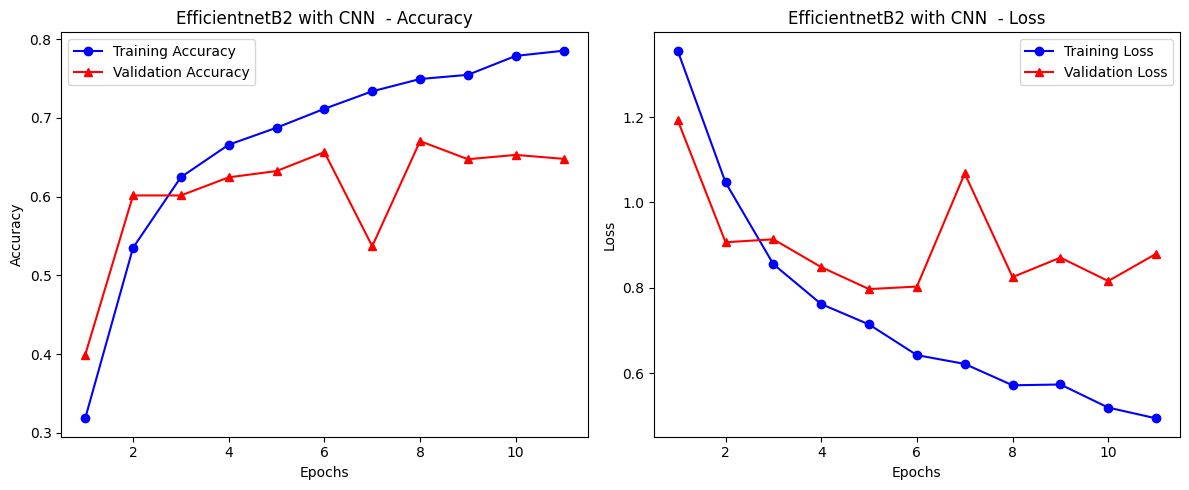

In [9]:
# Plotting for EfficientNetB2 with CNN
plot_history(history, model_name="EfficientnetB2 with CNN ")